# Analysis of data taken on Nov. 15: $T_1$ of salt water

In [1]:
# Some math and stats functions I'll need
%pylab inline
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.stats import sem, chisquare

# Seaborn helps make my plots prettier
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_context('paper', font_scale=1.4)

# Used to load and sort my data
from os import listdir
from natsort import natsorted
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define some useful functions I'll use many times
def load_data(dir_regex_str, pol_t_path):
    """Load the data from the directory selected by dir_regex_str and the pol_t_path
    INPUTS:
        - (String) dir_regex_str: Regex expression to find the directory with all the data for one concentration of salt.
        - (String)    pol_t_path: Relative path to a file containing the polarization times used.
    OUTPUTS:
        - (3D numpy array) data: the time domain signal for each run and polarization time.
        - (numpy array)       t: array of times sampled, this was kept the same for all runs. In ms.
        - (numpy array)   pol_t: array of polarization times used in ms.
    """
    
    data_dirs = natsorted(glob.glob(dir_regex_str))
    data_sets = [natsorted(glob.glob(ds + '/data*')) for ds in data_dirs]
    data = []
    for data_set in data_sets:
        data.append([np.loadtxt(f) for f in data_set])

    t = linspace(0, 1200, 12000)  # we kept the default time sampling for each trial, in ms
    pol_t = loadtxt(pol_t_path)
    return data, t, pol_t

In [3]:
def model(t, T1, M0, d):
    return M0 * (1-exp(-t/T1)) + d

In [135]:
def get_T1(data, pol_t, peak_lims = [[2.26, 2.28],[2.26, 2.28],[2.26, 2.28]], peak_widths=linspace(0.02, 0.03, 10),
            plot_fits = False,
            plot_signals = False,
            plot_residuals = False,
            plot_peak_lims = False,
            plot_T1s = False):
    
    cmap = plt.get_cmap('rainbow')  # colors for the plots 

    T1s = []      # store T1s calculated with different peak limits
    T1_errs = []  # store the errors associated with the T1s 
    chi2s = []    # store the chi2 values
    pvalues = []  # store p-values to evaluate goodness of fit

    for peak_width in peak_widths:
        peak_areas = zeros((shape(data)[0], len(pol_t)))
            
        for m in range(shape(data)[0]): # for each trial
            peak_lim = peak_lims[m]

            for n in range(len(pol_t)):  # for each polarization time
                # Calculate the discrete fourier transform and frequency
                F = fft.fft(data[m][n])
                freq = fft.fftfreq(len(F), .1)  # each step is 0.1ms
                peak = logical_and(freq > peak_lim[0], freq < peak_lim[1])  # logical index for locating the peak
                peak_max = max(abs(F[peak]))
                # redefine the peak area around the signal peak max
                peak_max_freq = freq[logical_and(abs(F) == peak_max, peak)]
                peak = logical_and(freq > peak_max_freq-peak_width/2, freq < peak_max_freq+peak_width/2)
                peak_areas[m][n] = simps(abs(F[peak]), freq[peak])  # calculate the area under the peak using simpson's rule

                avg_peak_areas = mean(peak_areas, axis=0)

                if plot_peak_lims and m==2 and (n==0 or n==7 or n==14):
                    if n==0:
                        figure(1)
                    if n==7:
                        figure(2)
                    if n==14:
                        figure(3)
                    #figure()  # uncomment to plot separately
                    c = cmap(float(n)/len(pol_t))
                    plot(freq, abs(F), color=c)
                    xlim([peak_lim[0]-.01, peak_lim[1]+.01])  # kHz
                    ylim([0, 350000])
                    axvline(freq[peak][0], linestyle='--', color=c)
                    axvline(freq[peak][-1], linestyle='--', color=c)

            err_peak_areas = sem(peak_areas, axis=0)
            popt, pcov = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=[2400, 800, 50])

            model_pnts = model(pol_t, *popt)
            chi2, p = chisquare(avg_peak_areas, model_pnts, ddof=3.)

            if plot_fits:
                figure()
                x = linspace(0,10000,10000)
                scatter(pol_t, avg_peak_areas)
                errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
                plot(model(x, *popt))
                xlabel('Polarization time (ms)')
                ylabel('Peak Areas')

            if plot_residuals:
                figure()
                residuals = avg_peak_areas - model_pnts
                scatter(pol_t, residuals)
                errorbar(pol_t, residuals, err_peak_areas, linestyle='None')
                hlines(0, 0, 10000, colors='r')
                xlabel('Polarization Time (ms)')
                ylabel('Residuals')

        T1s.append(popt[0])
        T1_errs.append(sqrt(diag(pcov))[0])
        pvalues.append(p)
        chi2s.append(chi2)

    return array(T1s), array(T1_errs), array(pvalues), array(chi2s)

## 10.22g of salt

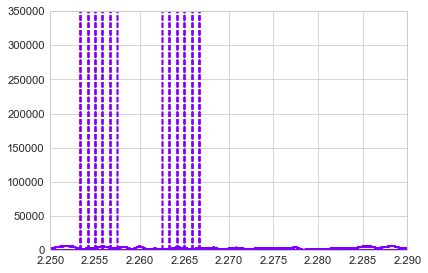

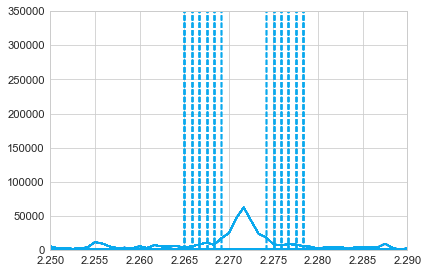

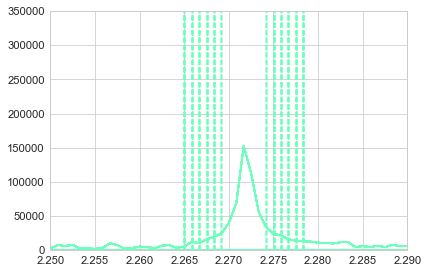

In [126]:
# load all the data for 10.22g of salt
data10, t, pol_t10 = load_data('./nov15/10*', './nov15/10_22gsaltwaterset1/array.txt')
peak_widths10 = linspace(0.006, 0.015, 50) # peak widths to try
T110, T1_errs10, pvalues10, chi2s10 = get_T1(data10, pol_t10, peak_widths=peak_widths10,plot_peak_lims=True)

(0.003, 0.016)

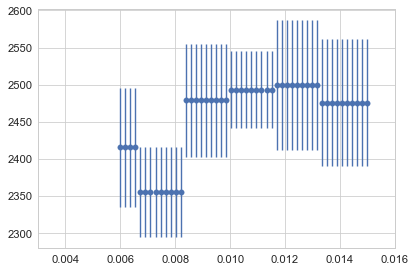

In [127]:
scatter(peak_widths10[pvalues10>0.05], T110[pvalues10>0.05])
errorbar(peak_widths10[pvalues10>0.05], T110[pvalues10>0.05], yerr=T1_errs10[pvalues10>0.05], linestyle='none')
xlim([0.003, 0.016])

(0.003, 0.016)

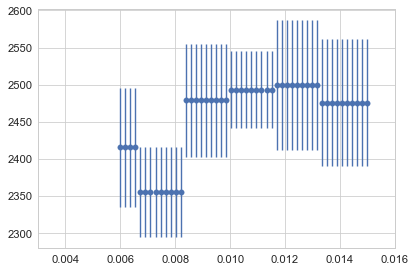

In [137]:
scatter(peak_widths10, T110)
errorbar(peak_widths10, T110, yerr=T1_errs10, linestyle='none')
xlim([0.003, 0.016])

In [138]:
pvalues10

array([ 0.31990942,  0.31990942,  0.31990942,  0.31990942,  0.2097326 ,
        0.2097326 ,  0.2097326 ,  0.2097326 ,  0.2097326 ,  0.2097326 ,
        0.2097326 ,  0.2097326 ,  0.2097326 ,  0.39083142,  0.39083142,
        0.39083142,  0.39083142,  0.39083142,  0.39083142,  0.39083142,
        0.39083142,  0.39083142,  0.09033185,  0.09033185,  0.09033185,
        0.09033185,  0.09033185,  0.09033185,  0.09033185,  0.09033185,
        0.09033185,  0.52731805,  0.52731805,  0.52731805,  0.52731805,
        0.52731805,  0.52731805,  0.52731805,  0.52731805,  0.52731805,
        0.1855562 ,  0.1855562 ,  0.1855562 ,  0.1855562 ,  0.1855562 ,
        0.1855562 ,  0.1855562 ,  0.1855562 ,  0.1855562 ,  0.1855562 ])

## 30.88g of salt

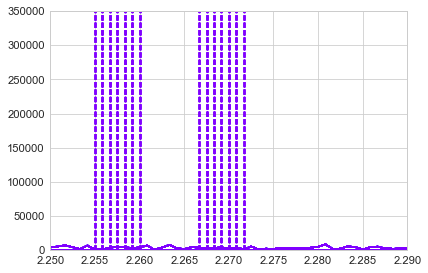

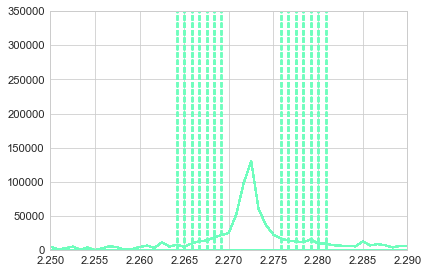

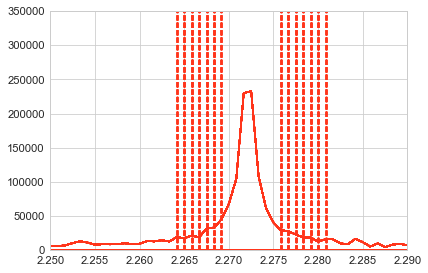

In [121]:
data30, t, pol_t30 = load_data('./nov15/30*', './nov15/30_88gsaltwaterset1/array.txt')
peak_widths30 = linspace(0.007, 0.018, 50) # peak widths to try
T130, T1_errs30, pvalues30, chi2s30 = get_T1(data30, pol_t30, peak_widths=peak_widths30, plot_peak_lims=True)

(0.005, 0.018)

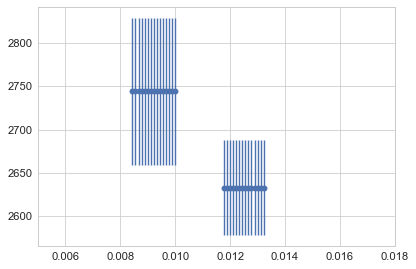

In [123]:
scatter(peak_widths30[pvalues30>0.05], T130[pvalues30>0.05])
errorbar(peak_widths30[pvalues30>0.05], T130[pvalues30>0.05], yerr=T1_errs30[pvalues30>0.05], linestyle='none')
xlim([0.005, 0.018])

(0.005, 0.018)

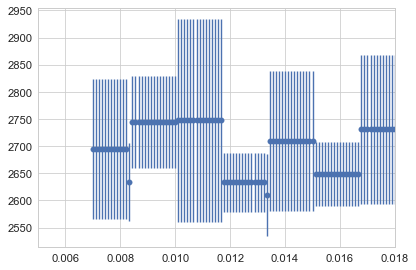

In [140]:
scatter(peak_widths30, T130)
errorbar(peak_widths30, T130, yerr=T1_errs30, linestyle='none')
xlim([0.005, 0.018])

In [139]:
pvalues30

array([  1.39704797e-02,   1.39704797e-02,   1.39704797e-02,
         1.39704797e-02,   1.39704797e-02,   1.39704797e-02,
         1.39704797e-02,   1.39704797e-02,   1.39704797e-02,
         1.39704797e-02,   1.39704797e-02,   1.39704797e-02,
         8.09807728e-03,   8.05465034e-01,   8.05465034e-01,
         8.05465034e-01,   8.05465034e-01,   8.05465034e-01,
         8.05465034e-01,   8.05465034e-01,   8.05465034e-01,
         8.05465034e-01,   8.05465034e-01,   8.05465034e-01,
         8.05465034e-01,   8.05465034e-01,   8.05465034e-01,
         8.05465034e-01,   1.10368987e-17,   1.10368987e-17,
         1.10368987e-17,   1.10368987e-17,   1.10368987e-17,
         1.10368987e-17,   1.10368987e-17,   1.10368987e-17,
         1.10368987e-17,   1.10368987e-17,   1.10368987e-17,
         1.10368987e-17,   1.10368987e-17,   1.10368987e-17,
         1.10368987e-17,   1.23262560e-01,   1.23262560e-01,
         1.23262560e-01,   1.23262560e-01,   1.23262560e-01,
         1.23262560e-01,

## 48.55g of salt

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


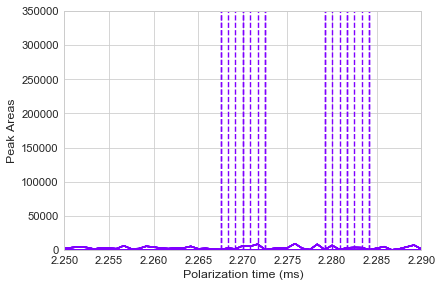

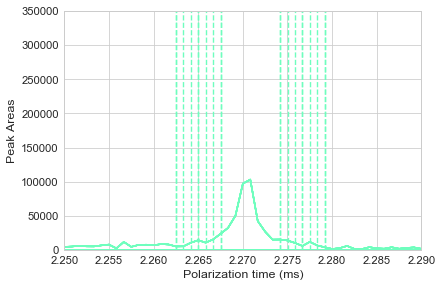

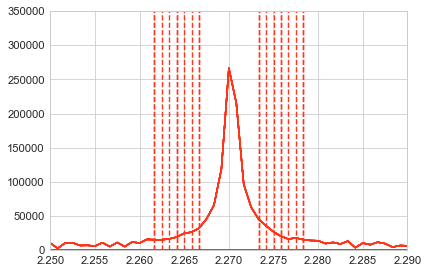

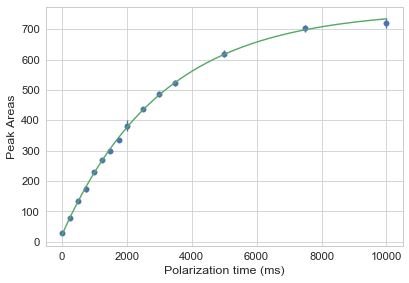

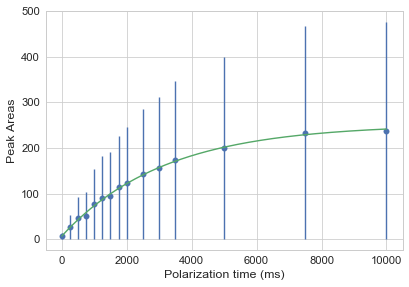

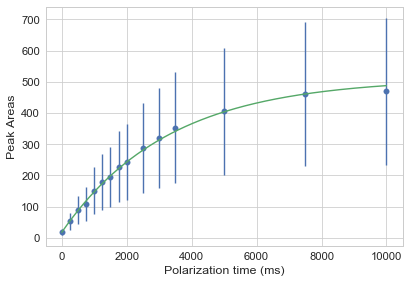

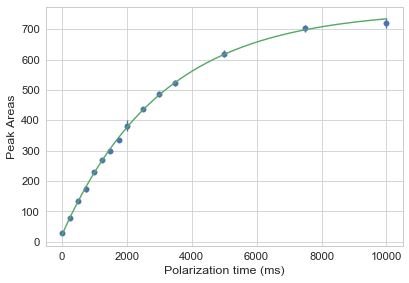

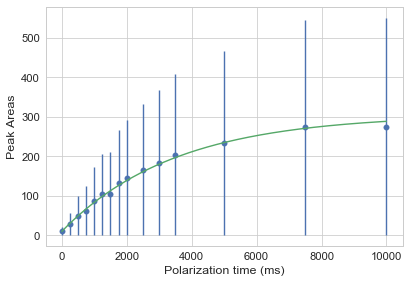

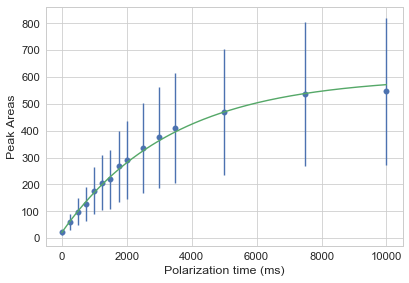

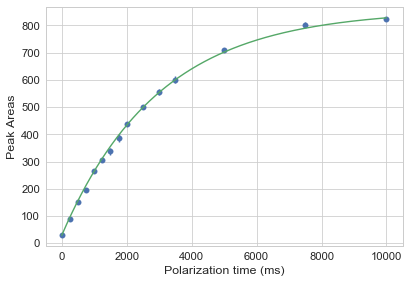

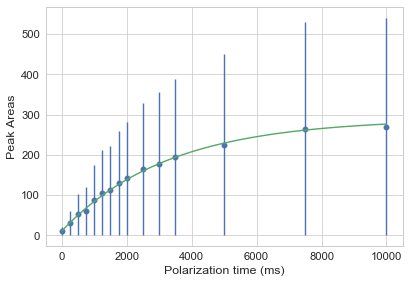

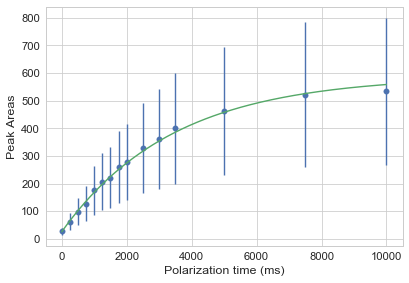

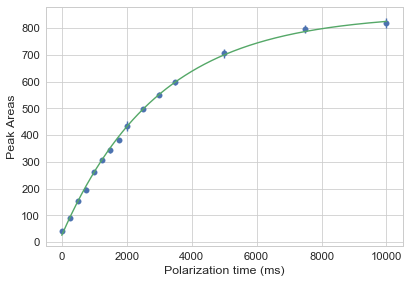

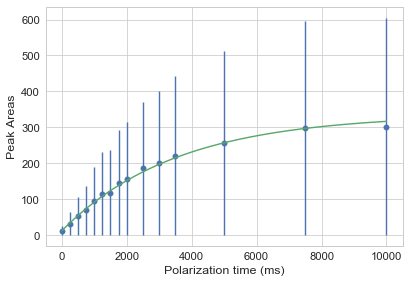

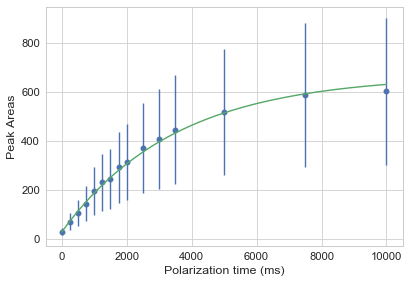

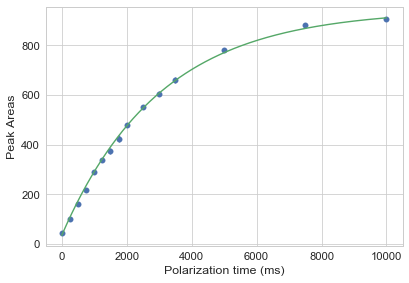

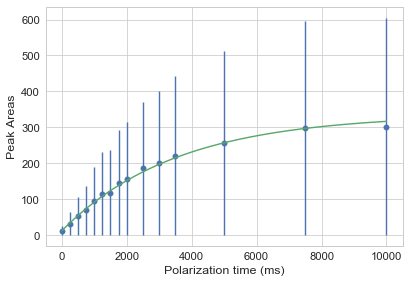

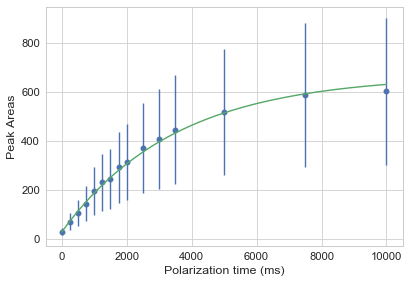

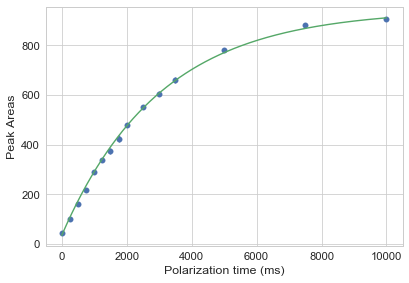

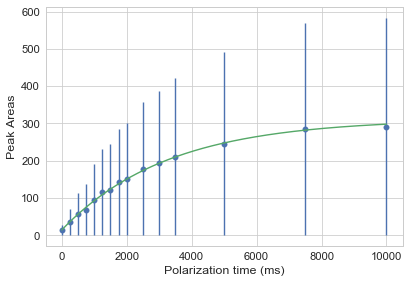

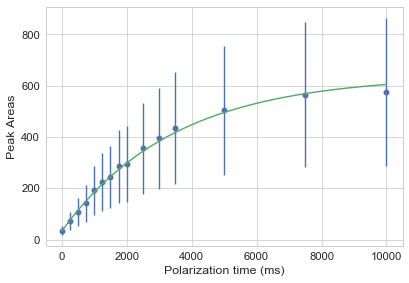

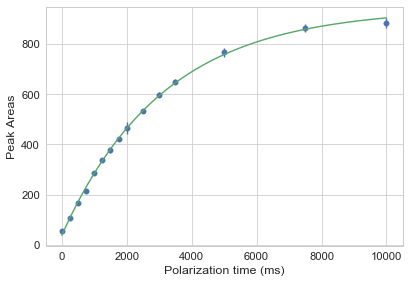

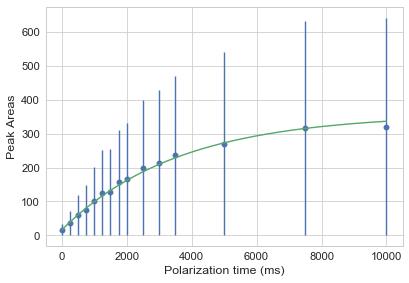

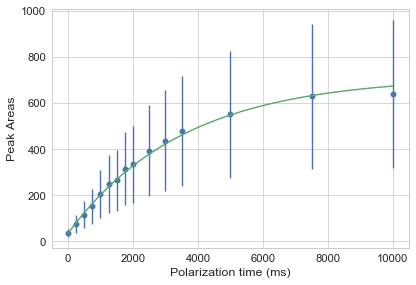

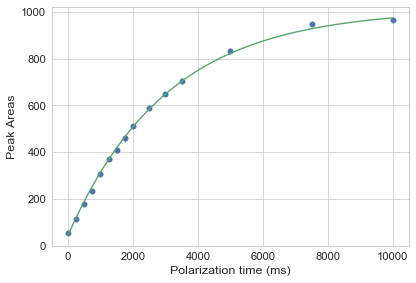

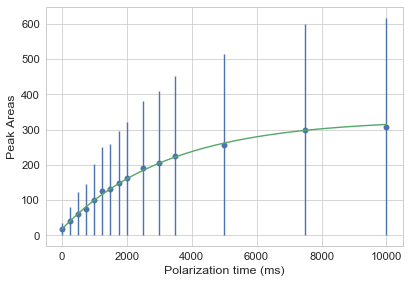

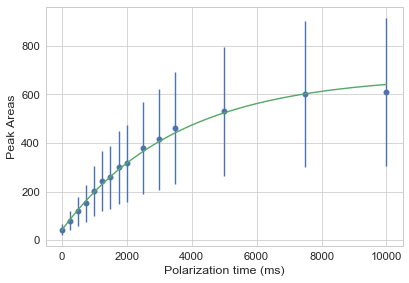

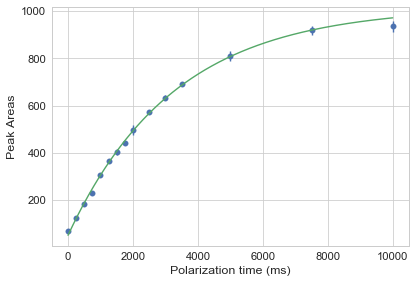

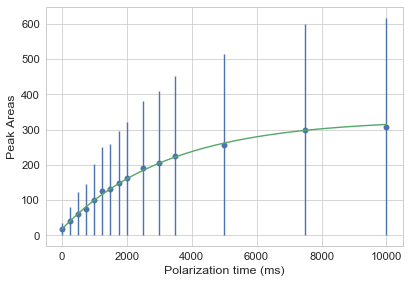

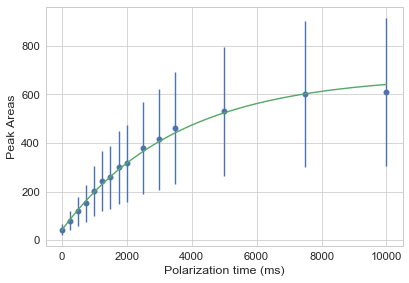

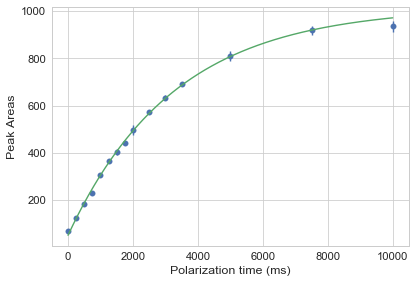

In [131]:
data48, t, pol_t48 = load_data('./nov15/48*', './nov15/48gsaltwaterset1/array.txt')
peak_widths48 = linspace(0.007, 0.018, 10) # peak widths to try
T1_48, T1_errs48, pvalues48, chi2s48 = get_T1(data48, pol_t48, peak_widths=peak_widths48, 
                                              plot_peak_lims=True, plot_fits=True)

(0.005, 0.02)

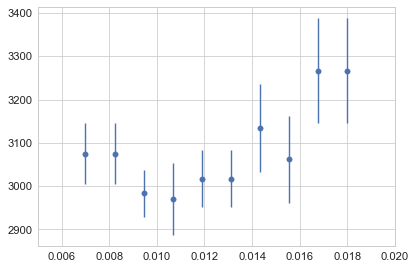

In [130]:
scatter(peak_widths48[pvalues48>0.05], T1_48[pvalues48>0.05])
errorbar(peak_widths48[pvalues48>0.05], T1_48[pvalues48>0.05], yerr=T1_errs48[pvalues48>0.05], linestyle='none')
xlim([0.005, 0.02])

(0.005, 0.02)

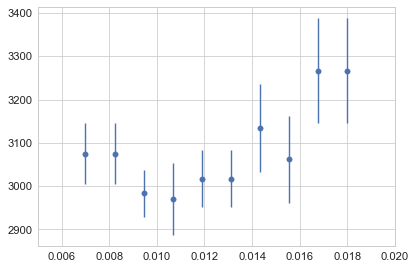

In [132]:
scatter(peak_widths48, T1_48)
errorbar(peak_widths48, T1_48, yerr=T1_errs48, linestyle='none')
xlim([0.005, 0.02])

In [141]:
pvalues48

array([ 0.98663751,  0.98663751,  0.95858284,  0.34323308,  0.8867497 ,
        0.8867497 ,  0.56451492,  0.84302066,  0.64858935,  0.64858935])